## Data

In [1]:
# import from google drive
# run this code piece, enter the autorization code
# For mount instructions: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

from google.colab import drive
drive.mount("/content/drive")

# or import from environment
PROJECT_DIR = "/content/drive/My Drive/Deep Learning System/project"

Mounted at /content/drive


In [2]:
%cd $PROJECT_DIR
# !git clone https://github.com/tuanpham96/bnn-cf-vs-robust "$PROJECT_DIR/bnn-cf-vs-robust"

# !conda config --add channels conda-forge  
# !conda create --name environment_name --file requirements.txt  
# !conda activate environment_name  
# !pip install pytorch==1.1.0 torchvision==0.3.0

/content/drive/My Drive/Deep Learning System/project


In [ ]:
# !unzip "/content/drive/My Drive/Deep Learning System/project/results.zip" -d "/content"

## Model

Reference: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

# PMNIST

In [ ]:
%cd $PROJECT_DIR/bnn-cf-vs-robust/src

from models_utils import BNN
from pmnist_robustness_data_utils import TaskDataSet

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))
])

common_dload_args = dict(
    batch_size  = 1
    # num_workers = args.num_workers,
    # pin_memory  = args.pin_memory
)

# train_dataset = TaskDataSet('/content/bnn-cf-vs-robust/data/input/pmnist_robustness/task-01/original/train', transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **common_dload_args)

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
for meta in ['0.00', '0.70', '1.35']:
  for task in range(1,7):
    test_dataset = TaskDataSet(f'/content/bnn-cf-vs-robust/data/input/pmnist_robustness/task-0{str(task)}/original/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, **common_dload_args)
    ckpt = torch.load(f'/content/bnn-cf-vs-robust/data/output/pmnist_robustness_[2048x2048]_[meta={meta}]/models/task-0{str(task)}.pt')
    model = BNN(**ckpt['model_args'])
    model.load_state_dict(ckpt['model_states'])
    model.eval()
    model.cuda()
    # Run test for each epsilon
    exa_i, acc_i = [], []
    for eps in epsilons:
        acc, ex = test(model, 'cuda:0', test_loader, eps)
        acc_i.append(acc)
        exa_i.append(ex)
    accuracies.append(acc_i)
    examples.append(exa_i)

/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src
Epsilon: 0	Test Accuracy = 9767 / 10000 = 0.9767
Epsilon: 0.05	Test Accuracy = 6972 / 10000 = 0.6972
Epsilon: 0.1	Test Accuracy = 2002 / 10000 = 0.2002
Epsilon: 0.15	Test Accuracy = 331 / 10000 = 0.0331
Epsilon: 0.2	Test Accuracy = 39 / 10000 = 0.0039
Epsilon: 0.25	Test Accuracy = 3 / 10000 = 0.0003
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0	Test Accuracy = 8621 / 10000 = 0.8621
Epsilon: 0.05	Test Accuracy = 4207 / 10000 = 0.4207
Epsilon: 0.1	Test Accuracy = 1584 / 10000 = 0.1584
Epsilon: 0.15	Test Accuracy = 565 / 10000 = 0.0565
Epsilon: 0.2	Test Accuracy = 140 / 10000 = 0.014
Epsilon: 0.25	Test Accuracy = 17 / 10000 = 0.0017
Epsilon: 0.3	Test Accuracy = 2 / 10000 = 0.0002
Epsilon: 0	Test Accuracy = 9246 / 10000 = 0.9246
Epsilon: 0.05	Test Accuracy = 5342 / 10000 = 0.5342
Epsilon: 0.1	Test Accuracy = 2085 / 10000 = 0.2085
Epsilon: 0.15	Test Accuracy = 598 / 10000 = 0.0598
Epsilon: 0.2	Test Accuracy 

In [ ]:
import numpy as np

np.savez(f'{PROJECT_DIR}/fgsm_examples.npz', np.array(examples))
np.savez(f'{PROJECT_DIR}/fgsm_acc_eps.npz', np.array(accuracies))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


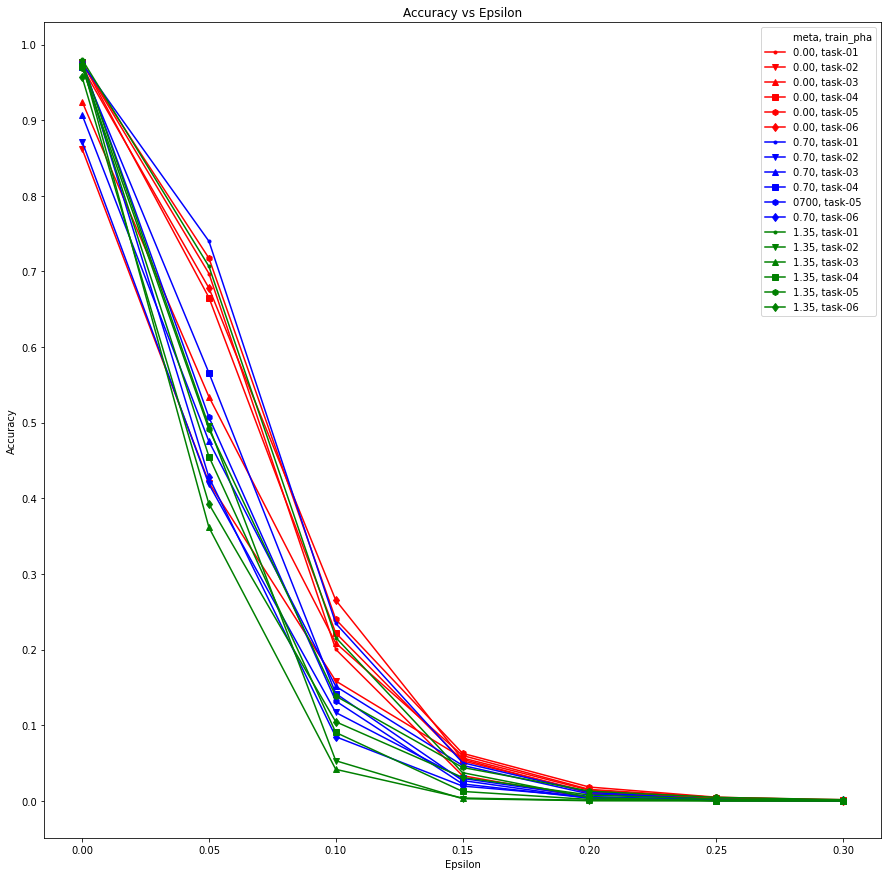

In [ ]:
%matplotlib inline
plt.close('all')

plt.figure(figsize=(15,15))
plt.plot([], [], ' ', label='meta, train_pha')
plt.plot(epsilons, accuracies[0], "r.-", label='0.00, task-01')
plt.plot(epsilons, accuracies[1], "rv-", label='0.00, task-02')
plt.plot(epsilons, accuracies[2], "r^-", label='0.00, task-03')
plt.plot(epsilons, accuracies[3], "rs-", label='0.00, task-04')
plt.plot(epsilons, accuracies[4], "rh-", label='0.00, task-05')
plt.plot(epsilons, accuracies[5], "rd-", label='0.00, task-06')
plt.plot(epsilons, accuracies[6], "b.-", label='0.70, task-01')
plt.plot(epsilons, accuracies[7], "bv-", label='0.70, task-02')
plt.plot(epsilons, accuracies[8], "b^-", label='0.70, task-03')
plt.plot(epsilons, accuracies[9], "bs-", label='0.70, task-04')
plt.plot(epsilons, accuracies[10], "bh-", label='0700, task-05')
plt.plot(epsilons, accuracies[11], "bd-", label='0.70, task-06')
plt.plot(epsilons, accuracies[12], "g.-", label='1.35, task-01')
plt.plot(epsilons, accuracies[13], "gv-", label='1.35, task-02')
plt.plot(epsilons, accuracies[14], "g^-", label='1.35, task-03')
plt.plot(epsilons, accuracies[15], "gs-", label='1.35, task-04')
plt.plot(epsilons, accuracies[16], "gh-", label='1.35, task-05')
plt.plot(epsilons, accuracies[17], "gd-", label='1.35, task-06')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

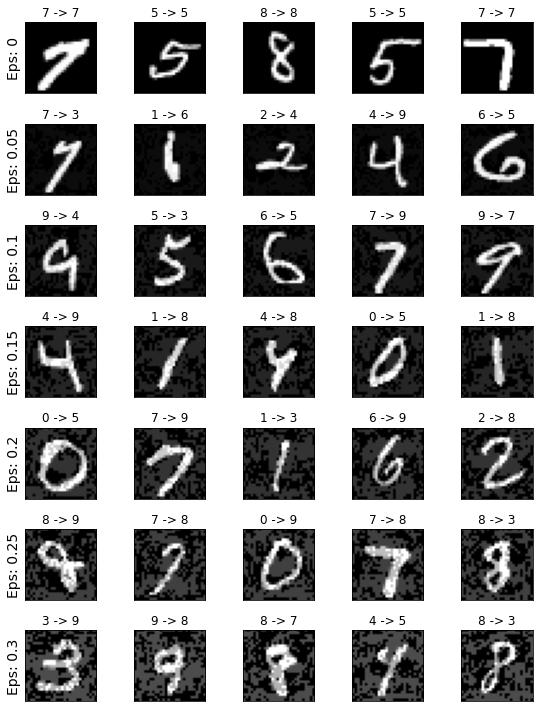

In [ ]:
# Plot several examples of adversarial samples at each epsilon
task = 0
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[task][i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[task][0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[task][i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# CIFAR10

In [41]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_value = image + epsilon*sign_data_grad
    return perturbed_value


In [42]:
class DatasetProcessing(torch.utils.data.Dataset):
  def __init__(self, data, target, transform=None):
      self.transform = transform
      self.data = data.astype(np.float32)[:,:,None]
      self.target = torch.from_numpy(target).long()
  def __getitem__(self, index):
      if self.transform is not None:
          return self.transform(self.data[index]), self.target[index]
      else:
          return self.data[index], self.target[index]
  def __len__(self):
      return len(list(self.data))

In [43]:
common_dload_args = dict(
    batch_size  = 1
    # num_workers = args.num_workers,
    # pin_memory  = args.pin_memory
)

In [44]:
import numpy as np

def relabel(label):
    label_map = [5,6,0,1,2,3,4,7,8,9]
    return label_map[label]

partition = np.vectorize(lambda l: l  < 5)

cifar_X_test = torch.load(f'{PROJECT_DIR}/cifar10_features_dataset/test.pt').cpu().numpy()
cifar_Y_test = torch.load(f'{PROJECT_DIR}/cifar10_features_dataset/test_targets.pt').cpu().numpy()

vrelabel = np.vectorize(relabel)
cifar_Y_test = vrelabel(cifar_Y_test)

dset_X1 = cifar_X_test[partition(cifar_Y_test)]
dset_y1 = cifar_Y_test[partition(cifar_Y_test)]
dset_X2 = cifar_X_test[np.logical_not(partition(cifar_Y_test))]
dset_y2 = cifar_Y_test[np.logical_not(partition(cifar_Y_test))]

dset_X1 = ( dset_X1 - dset_X1.mean(axis=1, keepdims = True) ) /dset_X1.var(axis = 1, keepdims = True)
dset_X2 = ( dset_X2 - dset_X2.mean(axis=1, keepdims = True) ) /dset_X2.var(axis = 1, keepdims = True)


dset_test1 = DatasetProcessing(dset_X1, dset_y1)
dset_test2 = DatasetProcessing(dset_X2, dset_y2)
test_loader1 = torch.utils.data.DataLoader(dset_test1, shuffle=True, **common_dload_args)
test_loader2 = torch.utils.data.DataLoader(dset_test2, shuffle=True, **common_dload_args)

In [45]:
%cd $PROJECT_DIR/bnn-cf-vs-robust/src

from models_utils import BNN
from pmnist_robustness_data_utils import TaskDataSet


meta_to_dir = {
    '0.0': 'results/2021-11-29/01-04-46_gpu0',
    '1.0': 'results/2021-11-29/01-10-44_gpu0',
    '1.3': 'results/2021-11-29/01-16-45_gpu0'
}

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
for meta in ['0.0', '1.0', '1.3']:
  ckpt0 = torch.load(f'{PROJECT_DIR}/{meta_to_dir[meta]}/vehicles_animals_0.pt')
  model0 = BNN(**ckpt0['model_args'])
  model0.load_state_dict(ckpt0['model_states'])
  model0.eval()
  model0.cuda()
  ckpt1 = torch.load(f'{PROJECT_DIR}/{meta_to_dir[meta]}/vehicles_animals_1.pt')
  model1 = BNN(**ckpt1['model_args'])
  model1.load_state_dict(ckpt1['model_states'])
  model1.eval()
  model1.cuda()
  # Run test for each epsilon
  exa_i, acc_i = [], []
  for eps in epsilons:
      acc, ex = test(model1, 'cuda:0', test_loader1, eps)
      acc_i.append(acc)
      exa_i.append(ex)
  accuracies.append(acc_i)
  exa_i, acc_i = [], []
  for eps in epsilons:
      acc, ex = test(model0, 'cuda:0', test_loader2, eps)
      acc_i.append(acc)
      exa_i.append(ex)
  accuracies.append(acc_i)
  examples.append(exa_i)

/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src
Epsilon: 0	Test Accuracy = 3873 / 5000 = 0.7746
Epsilon: 0.05	Test Accuracy = 3180 / 5000 = 0.636
Epsilon: 0.1	Test Accuracy = 2380 / 5000 = 0.476
Epsilon: 0.15	Test Accuracy = 1564 / 5000 = 0.3128
Epsilon: 0.2	Test Accuracy = 889 / 5000 = 0.1778
Epsilon: 0.25	Test Accuracy = 428 / 5000 = 0.0856
Epsilon: 0.3	Test Accuracy = 169 / 5000 = 0.0338
Epsilon: 0	Test Accuracy = 4447 / 5000 = 0.8894
Epsilon: 0.05	Test Accuracy = 3977 / 5000 = 0.7954
Epsilon: 0.1	Test Accuracy = 3303 / 5000 = 0.6606
Epsilon: 0.15	Test Accuracy = 2512 / 5000 = 0.5024
Epsilon: 0.2	Test Accuracy = 1734 / 5000 = 0.3468
Epsilon: 0.25	Test Accuracy = 1076 / 5000 = 0.2152
Epsilon: 0.3	Test Accuracy = 600 / 5000 = 0.12
Epsilon: 0	Test Accuracy = 3754 / 5000 = 0.7508
Epsilon: 0.05	Test Accuracy = 3369 / 5000 = 0.6738
Epsilon: 0.1	Test Accuracy = 2954 / 5000 = 0.5908
Epsilon: 0.15	Test Accuracy = 2485 / 5000 = 0.497
Epsilon: 0.2	Test Accuracy = 2080

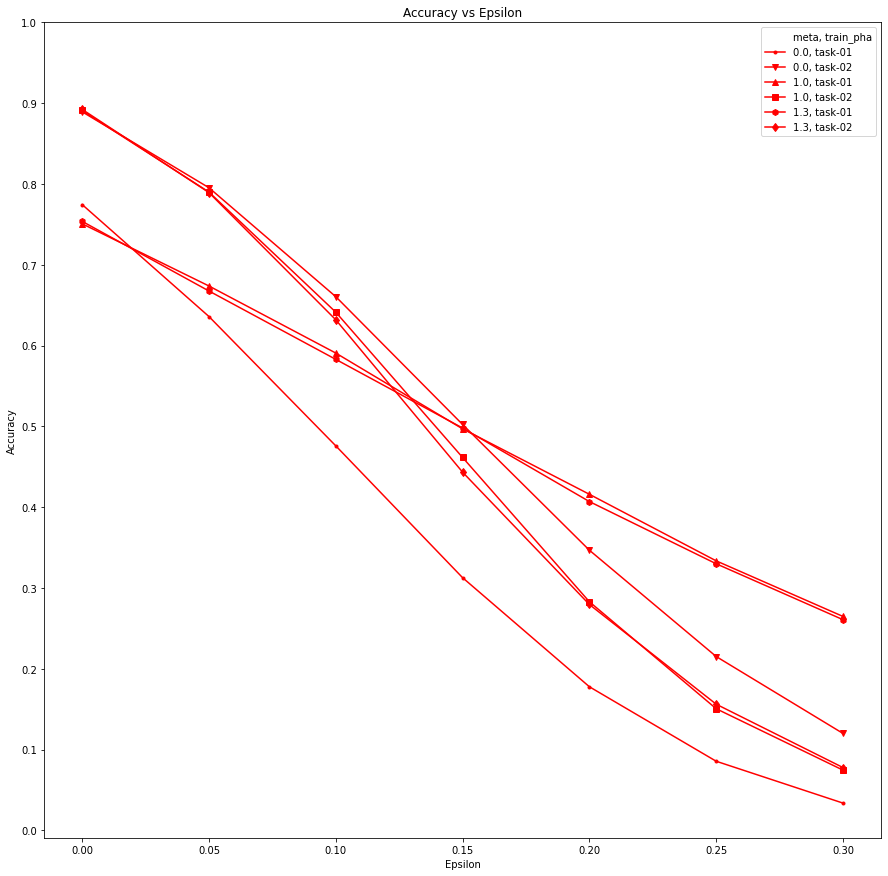

In [46]:
%matplotlib inline
plt.close('all')

plt.figure(figsize=(15,15))
plt.plot([], [], ' ', label='meta, train_pha')
plt.plot(epsilons, accuracies[0], "r.-", label='0.0, task-01')
plt.plot(epsilons, accuracies[1], "rv-", label='0.0, task-02')
plt.plot(epsilons, accuracies[2], "r^-", label='1.0, task-01')
plt.plot(epsilons, accuracies[3], "rs-", label='1.0, task-02')
plt.plot(epsilons, accuracies[4], "rh-", label='1.3, task-01')
plt.plot(epsilons, accuracies[5], "rd-", label='1.3, task-02')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

In [47]:
n_subset = 6
subset_size = 100//n_subset

test_loader_list = []

cifar100_X_test = torch.load(f'{PROJECT_DIR}/cifar100_features_dataset/test.pt').cpu().numpy()
cifar100_Y_test = torch.load(f'{PROJECT_DIR}/cifar100_features_dataset/test_targets.pt').cpu().numpy()

for k in range(n_subset):
    partition = np.vectorize(lambda l: ((l < (k+1)*subset_size) and (l >= k*subset_size)) )
    sub_X_test = cifar100_X_test[partition(cifar100_Y_test)]
    sub_X_test = ( sub_X_test - sub_X_test.mean(axis=1, keepdims = True) ) /sub_X_test.var(axis = 1, keepdims = True)
    sub_Y_test = cifar100_Y_test[partition(cifar100_Y_test)]
    sub_dset_test = DatasetProcessing(sub_X_test, sub_Y_test)
    sub_test_loader = torch.utils.data.DataLoader(sub_dset_test, batch_size=1, shuffle=False, num_workers=0)
    test_loader_list.append(sub_test_loader)    

In [48]:
%cd $PROJECT_DIR/bnn-cf-vs-robust/src

from models_utils import BNN
from pmnist_robustness_data_utils import TaskDataSet


meta_to_dir = {
    '0.0': 'results/2021-11-29/01-22-44_gpu0',
    '1.0': 'results/2021-11-29/01-30-39_gpu0',
    '1.3': 'results/2021-11-29/01-38-30_gpu0'
}

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
for meta in ['0.0', '1.0', '1.3']:
  for k in range(6):
    ckpt = torch.load(f'{PROJECT_DIR}/{meta_to_dir[meta]}/cifar100-6_{k}.pt')
    model = BNN(**ckpt['model_args'])
    model.load_state_dict(ckpt['model_states'])
    model.eval()
    model.cuda()
    # Run test for each epsilon
    exa_i, acc_i = [], []
    for eps in epsilons:
        acc, ex = test(model, 'cuda:0', test_loader_list[k], eps)
        acc_i.append(acc)
        exa_i.append(ex)
    accuracies.append(acc_i)
    examples.append(exa_i)

/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src
Epsilon: 0	Test Accuracy = 1295 / 1600 = 0.809375
Epsilon: 0.05	Test Accuracy = 1082 / 1600 = 0.67625
Epsilon: 0.1	Test Accuracy = 873 / 1600 = 0.545625
Epsilon: 0.15	Test Accuracy = 662 / 1600 = 0.41375
Epsilon: 0.2	Test Accuracy = 492 / 1600 = 0.3075
Epsilon: 0.25	Test Accuracy = 352 / 1600 = 0.22
Epsilon: 0.3	Test Accuracy = 249 / 1600 = 0.155625
Epsilon: 0	Test Accuracy = 1299 / 1600 = 0.811875
Epsilon: 0.05	Test Accuracy = 1135 / 1600 = 0.709375
Epsilon: 0.1	Test Accuracy = 956 / 1600 = 0.5975
Epsilon: 0.15	Test Accuracy = 756 / 1600 = 0.4725
Epsilon: 0.2	Test Accuracy = 580 / 1600 = 0.3625
Epsilon: 0.25	Test Accuracy = 431 / 1600 = 0.269375
Epsilon: 0.3	Test Accuracy = 306 / 1600 = 0.19125
Epsilon: 0	Test Accuracy = 1215 / 1600 = 0.759375
Epsilon: 0.05	Test Accuracy = 1001 / 1600 = 0.625625
Epsilon: 0.1	Test Accuracy = 800 / 1600 = 0.5
Epsilon: 0.15	Test Accuracy = 615 / 1600 = 0.384375
Epsilon: 0.2	Test Ac

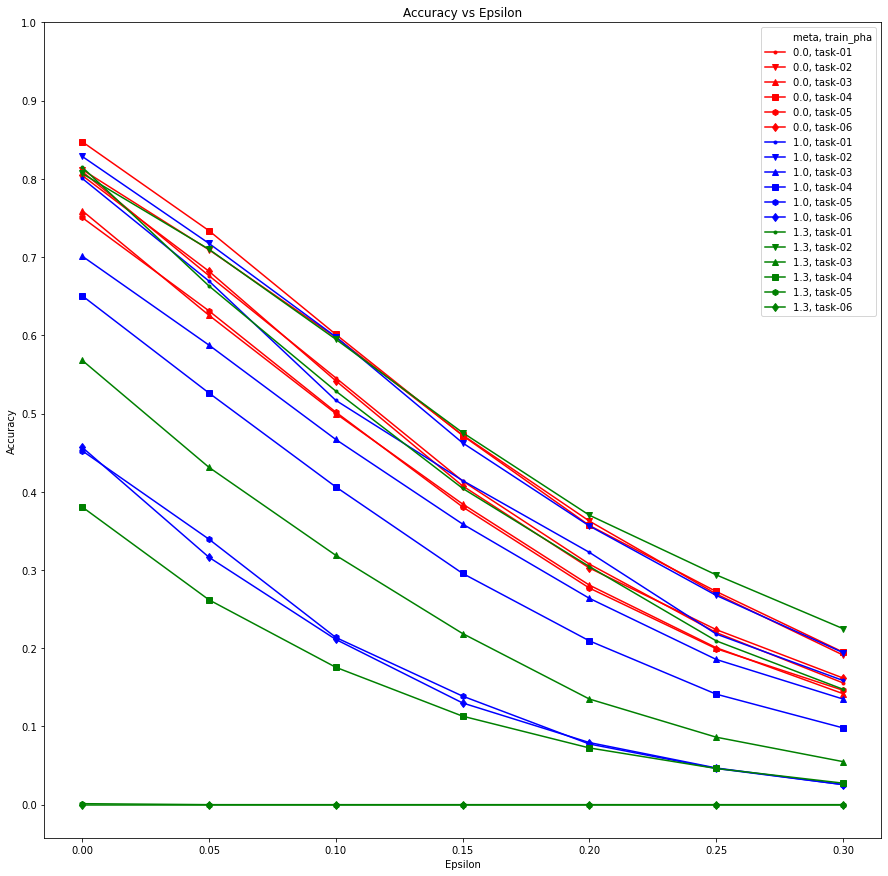

In [49]:
%matplotlib inline
plt.close('all')

plt.figure(figsize=(15,15))
plt.plot([], [], ' ', label='meta, train_pha')
plt.plot(epsilons, accuracies[0], "r.-", label='0.0, task-01')
plt.plot(epsilons, accuracies[1], "rv-", label='0.0, task-02')
plt.plot(epsilons, accuracies[2], "r^-", label='0.0, task-03')
plt.plot(epsilons, accuracies[3], "rs-", label='0.0, task-04')
plt.plot(epsilons, accuracies[4], "rh-", label='0.0, task-05')
plt.plot(epsilons, accuracies[5], "rd-", label='0.0, task-06')
plt.plot(epsilons, accuracies[6], "b.-", label='1.0, task-01')
plt.plot(epsilons, accuracies[7], "bv-", label='1.0, task-02')
plt.plot(epsilons, accuracies[8], "b^-", label='1.0, task-03')
plt.plot(epsilons, accuracies[9], "bs-", label='1.0, task-04')
plt.plot(epsilons, accuracies[10], "bh-", label='1.0, task-05')
plt.plot(epsilons, accuracies[11], "bd-", label='1.0, task-06')
plt.plot(epsilons, accuracies[12], "g.-", label='1.3, task-01')
plt.plot(epsilons, accuracies[13], "gv-", label='1.3, task-02')
plt.plot(epsilons, accuracies[14], "g^-", label='1.3, task-03')
plt.plot(epsilons, accuracies[15], "gs-", label='1.3, task-04')
plt.plot(epsilons, accuracies[16], "gh-", label='1.3, task-05')
plt.plot(epsilons, accuracies[17], "gd-", label='1.3, task-06')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()